In [1]:
# библиотеки для работы с данными
import numpy as np
import pandas as pd
from scipy.sparse import lil_matrix

# библиотеки для визуализации
import matplotlib.pyplot as pyplot
from matplotlib import cm
%matplotlib inline

# библиотеки для работы со временем и датами
import datetime
import math
from time import strftime

### Загружаем и чистим данные

In [2]:
events = pd.read_csv("02_Data_test.csv", sep=";", low_memory=False)
known_personas_data = pd.read_excel("01_Факты.xlsx", header=None)

In [3]:
# замещаем пропуски IMEI нулями
events.loc[events["imei"] == "null", "imei"] = 0
events.loc[events["imei"] == "NaN", "imei"] = 0
events["imei"].fillna(value=0, inplace=True)
events["imei"] = events["imei"].astype(np.int64)

# создаём новые признаки для более удобного анализа времени событий
events["time"] = events["tstamp"].apply(
    lambda tstamp: datetime.datetime.fromtimestamp(tstamp/1000).strftime("%Y-%m-%d %H:%M:%S")
)

events["time_minutes"] = events["tstamp"].apply(
    lambda tstamp: int(tstamp/(1000*60))
)

# для базовой станции создаём признаки расположения и уникальные id
events["station_location"] = events.ix[:,"lat"].map(str) + ", " + events.ix[:,"long"].map(str)
events["station_id"] = events.ix[:,"lac"].map(str) + events.ix[:,"cid"].map(str) + " " + events.ix[:,"station_location"].map(str)

### Определяем степень сходства сим-карт между собой

#### Гипотеза 1
Сим-карты схожи между собой, если события с сим-картами возникают в одних и тех же местах в одном интервале времени.

В качестве быстрого решения сходство мест возникновения событий определяется по сходству координат базовых станций, а интервал времени условно принимается за 8 часов. Мерой сходства будет количество событий, по которым выполнены оба условия.

In [158]:
# выделяем вспомогательные данные для анализа
unique_msisdns = events["msisdn"].unique()
# основная разреженная матрица, куда будет сохраняться мера схожести пары сим-карт
msisdns_pairs_matrix = lil_matrix((len(unique_msisdns), len(unique_msisdns)), dtype="float")

# группируем все события в исходных данных по отдельным сим-картам для сокращения времени запроса в основную выборку
msisdn_events = []
for msisdn in unique_msisdns:
    msisdn_events.append(events[events["msisdn"] == msisdn])

In [159]:
time_similarity_threshold = 1*60

print("Старт обработки выборки:", strftime("%Y-%m-%d %H:%M:%S"))

# последовательно обходим матрицу попарной схожести сим-карт, работая только с верхней диагональю для исключения избыточности расчётов
for msisdn_row in range(len(unique_msisdns)):
    print(strftime("%Y-%m-%d %H:%M:%S"),"Обрабатываю строку", (msisdn_row+1), "из", len(unique_msisdns)+1)
    msisdn_row_entries = msisdn_events[msisdn_row]
    for msisdn_column in range(msisdn_row, len(unique_msisdns)):
        similarity_value = 0
        
        # диагональ, на которой лежит соответствие сим-карте самой себе, игнорируем
        if msisdn_column == msisdn_row:
            continue
        
        # ищем схожесть пары симок
        # сначала определяем, есть ли среди событий у пары сим-карт совпадающие расположения вышек
        common_locations = np.intersect1d(msisdn_events[msisdn_row]["station_location"].unique(),
                                          msisdn_events[msisdn_column]["station_location"].unique(), assume_unique=True)
        # если совпадения по расположению вышек найдены, вычисляем попарную разницу во времени событий на этих базовых станциях
        # если события призошли в одном интервале, считаем их схожими
        if common_locations.size > 0:
            msisdn_column_entries = msisdn_events[msisdn_column]
            for common_location in common_locations:
                for msisdn1_time in msisdn_row_entries.ix[msisdn_row_entries["station_location"] == common_location, "time_minutes"].values:
                    for msisdn2_time in msisdn_column_entries.ix[msisdn_column_entries["station_location"] == common_location, "time_minutes"].values:
                        if abs(msisdn1_time - msisdn2_time) < time_similarity_threshold:
                            similarity_value += 1
        
        # экономим память, записывая в разреженную матрицу только ненулевые количества схожих событий
        if similarity_value > 0:
            msisdns_pairs_matrix[msisdn_row, msisdn_column] = similarity_value
            
print("Конец обработки выборки:", strftime("%Y-%m-%d %H:%M:%S"))

Старт обработки выборки: 2016-06-22 12:08:28
2016-06-22 12:08:28 Обрабатываю строку 1 из 2362
2016-06-22 12:08:43 Обрабатываю строку 2 из 2362
2016-06-22 12:08:44 Обрабатываю строку 3 из 2362
2016-06-22 12:09:05 Обрабатываю строку 4 из 2362
2016-06-22 12:09:27 Обрабатываю строку 5 из 2362
2016-06-22 12:09:52 Обрабатываю строку 6 из 2362
2016-06-22 12:09:52 Обрабатываю строку 7 из 2362
2016-06-22 12:10:00 Обрабатываю строку 8 из 2362
2016-06-22 12:10:05 Обрабатываю строку 9 из 2362
2016-06-22 12:10:14 Обрабатываю строку 10 из 2362
2016-06-22 12:10:16 Обрабатываю строку 11 из 2362
2016-06-22 12:10:31 Обрабатываю строку 12 из 2362
2016-06-22 12:10:57 Обрабатываю строку 13 из 2362
2016-06-22 12:11:10 Обрабатываю строку 14 из 2362
2016-06-22 12:11:26 Обрабатываю строку 15 из 2362
2016-06-22 12:11:29 Обрабатываю строку 16 из 2362
2016-06-22 12:11:37 Обрабатываю строку 17 из 2362
2016-06-22 12:11:47 Обрабатываю строку 18 из 2362
2016-06-22 12:11:48 Обрабатываю строку 19 из 2362
2016-06-22 12:

#### Гипотеза 1
Сим-карты схожи между собой, если события с сим-картами возникают в одних и тех же местах в одном интервале времени.

Сходство мест возникновения события определяется по пересечению зон покрытия станций. Зоны покрытия для ускорения расчётов аппроксимируются набором треугольников с центром в координатах базовой станции и углом раскрытия <= 45 градусам.

Интервал времени принимается равным 24 часам.

In [48]:
# выделяем вспомогательные величины для анализа
stations = events.ix[:,["station_id","station_location","long","lat","max_dist","start_angle","end_angle"]].drop_duplicates()
unique_stations = stations["station_id"].unique()
unique_msisdns = events["msisdn"].unique()
# основная разреженная матрица, куда будет сохраняться мера схожести пары сим-карт
msisdns_pairs_matrix = lil_matrix((len(unique_msisdns), len(unique_msisdns)), dtype="float")
# вспомогательные разреженные матрицы для вычисления попарного пересечения зон покрытия базовых станций
# в visited_intersects_matrix запоминаем, обсчитывалось ли уже пересечение зон на этой паре станций для предотвращения дублирующих расчётов
# в stations_intersect_matrix будет храниться признак пересечения зон покрытия
visited_intersects_matrix = lil_matrix((len(unique_stations), len(unique_stations)), dtype="bool")
stations_intersect_matrix = lil_matrix((len(unique_stations), len(unique_stations)), dtype="bool")

In [193]:
time_similarity_threshold = 24*60

# определяем вспомогательные функции для расчётов
# функцией detect_coverage_intersection будем определять пересечение зон покрытия для заданной пары станций

# используем стороннюю библиотеку Shapely для упрощения работы с геом. фигурами на плоскости
from shapely.geometry import Polygon, Point
# приближённо определяем величину одного градуса широты и долготы в метрах
# https://en.wikipedia.org/wiki/Earth
metres_to_degrees = 40007.86 * 1000.0 / 360.0

# заранее рассчитываем порядковые номера признаков для адресации в выборке, чтобы не считать их на каждом шаге цикла
station_location_index = np.where(stations.keys() == "station_location")[0][0]
long_index = np.where(stations.keys() == "long")[0][0]
lat_index = np.where(stations.keys() == "lat")[0][0]
max_dist_index = np.where(stations.keys() == "max_dist")[0][0]
start_angle_index = np.where(stations.keys() == "start_angle")[0][0]
end_angle_index = np.where(stations.keys() == "end_angle")[0][0]

def detect_coverage_intersection(station1_id, station2_id):
    # если станции совпадают, нам повезло
    if station1_id == station2_id:
        return True
        
    station1_number = np.where(unique_stations == station1_id)[0][0]
    station2_number = np.where(unique_stations == station2_id)[0][0]
    
    # работаем только с верхним треугольником в матрицах пересечения зон покрытия станций
    if station1_number > station2_number:
        temp = station2_number
        station2_number = station1_number
        station1_number = temp
    
    # если раньше уже рассчитывался признак пересечения двух станций, возвращаем его, чтобы не считать ещё раз
    if visited_intersects_matrix[station1_number, station2_number]:
        return stations_intersect_matrix[station1_number, station2_number]
    
    # запоминаем признаки двух станций заранее для экономия времени во времени на запрос в выборку
    station1_index = np.where(stations["station_id"] == station1_id)[0][0]
    st1_location = stations.iat[station1_index, station_location_index]
    st1_start_angle = stations.iat[station1_index, start_angle_index]
    st1_end_angle = stations.iat[station1_index, end_angle_index]
    st1_max_dist = stations.iat[station1_index, max_dist_index]
    st1_long = stations.iat[station1_index, long_index]
    st1_lat = stations.iat[station1_index, lat_index]
    
    station2_index = np.where(stations["station_id"] == station2_id)[0][0]
    st2_location = stations.iat[station2_index, station_location_index]
    st2_start_angle = stations.iat[station2_index, start_angle_index]
    st2_end_angle = stations.iat[station2_index, end_angle_index]
    st2_max_dist = stations.iat[station2_index, max_dist_index]
    st2_long = stations.iat[station2_index, long_index]
    st2_lat = stations.iat[station2_index, lat_index]
    
    # в качестве быстрого приближения представляем зоны покрытия станции двумя кругами с центром в координатах станции
    # и радиусом равным дистанции приема.
    # если круги не пересекаются, дальнейшая проверка бессмысленна
    station1_circle_area = Point(st1_long, st1_lat).buffer(st1_max_dist / metres_to_degrees)
    station2_circle_area = Point(st2_long, st2_lat).buffer(st2_max_dist / metres_to_degrees)

    if station1_circle_area.intersects(station2_circle_area):
        # круги пересекаются, проверяем пересекаются ли зоны покрытия
        # зону покрытия аппроксимируем смежными треугольниками и проверяем их попарные пересечения
        # если есть хоть одно пересечение, зоны покрытия базовы станций пересекаются
        station1_triangles = approximate_coverage_area(st1_start_angle, st1_end_angle, st1_max_dist, st1_long, st1_lat)
        station2_triangles = approximate_coverage_area(st2_start_angle, st2_end_angle, st2_max_dist, st2_long, st2_lat)

        for station1_triangle in station1_triangles:
            for station2_triangle in station2_triangles:
                if station1_triangle.intersects(station2_triangle):
                    # запоминаем признак пересечения, чтобы не рассчитывать его дважды
                    mark_as_visited(station1_number, station2_number, True)
                    return True
                    break
        # если ни одна пара треугольников не пересекается, то и зоны покрытия не пересекаются
        mark_as_visited(station1_number, station2_number, False)
        return False
    else:
        mark_as_visited(station1_number, station2_number, False)
        return False

# обёртка вокруг матриц попарного пересечения зоны покрытия станций
# запоминаем, какие станции мы уже обсчитали, и результат расчёта на этих станциях, экономя место в разреженных матрицах
def mark_as_visited(station1_index, station2_index, result):
    # работаем только с верхним треугольником в матрицах
    if station1_index <= station2_index:
        visited_intersects_matrix[station1_index, station2_index] = True
        if result: stations_intersect_matrix[station1_index, station2_index] = result
    else:
        visited_intersects_matrix[station2_index, station1_index] = True
        if result: stations_intersect_matrix[station2_index, station1_index] = result

# функция для расчёта координат треугольников, аппроксимирующая зону покрытия станции
def approximate_coverage_area(start_angle, end_angle, max_dist, long, lat):
    event_triangles = []
    # вычисляем начальные и конечные азимуты треугольников
    angle_boundaries = calculate_angle_boundaries(start_angle, end_angle)
    # разбиваем зону покрытия станции на отдельные треугольники
    for index, angle_boundary in enumerate(angle_boundaries):
        # пользуясь библиотекой Shapely, представляем треугольник полигоном из точек расположения базовой станции и границ зоны покрытия
        event_triangles.append(Polygon([
                                    (long, lat),
                                    calculate_destination_point(long, lat, max_dist, angle_boundary[0]),
                                    calculate_destination_point(long, lat, max_dist, angle_boundary[1])
                                ]))
    return event_triangles

# условно принимаем максимальным угол раскрытия треугольника в 45 градусов
dividing_angle = 45

def calculate_angle_boundaries(start_angle, end_angle):
    angle_boundaries = []
    # подсчитываем, сколько треугольников может получиться из таких угловых границ и размера шага
    if end_angle > start_angle:
        triangles_count = math.ceil((end_angle - start_angle) / dividing_angle)
    else:
        # если зона покрытия пересекает 360 градусов, считаем по-другому
        triangles_count = math.ceil((end_angle - (start_angle-360)) / dividing_angle)
    
    # считаем азимуты для каждого треугольника
    for i in range(triangles_count):
        start_bearing = start_angle + i*dividing_angle
        end_bearing = start_angle + (i+1)*dividing_angle
        # если азимут вылез за 360 градусов, считаем по-другому
        if start_bearing > 360:
            start_bearing = start_bearing - 360
        if end_bearing > 360:
            end_bearing = end_bearing - 360
        
        angle_boundaries.append([start_bearing, min(end_bearing, end_angle)])
    return angle_boundaries

# рассчитываем координаты точки границы зоны покрытия базовой станции,
# зная координаты самой станции, дистанцию покрытия и азимут границы зоны покрытия
# источник алгоритма: http://www.movable-type.co.uk/scripts/latlong.html
def calculate_destination_point(start_longitude, start_latitude, distance, bearing):
    # преобразуем дистанцию покрытия в угловое расстояние
    ang_distance = distance / (6371.0 * 1000.0)
    # переводим углы в радианы
    long_rad = math.radians(start_longitude)
    lat_rad = math.radians(start_latitude)
    bearing_rad = math.radians(bearing)
    
    # чёрная магия, и потом координаты переводим обратно в градусы
    destination_lat_rad = math.asin(math.sin(lat_rad) * math.cos(ang_distance) + math.cos(lat_rad) * math.sin(ang_distance) * math.cos(bearing_rad))
    destination_long_rad = long_rad + math.atan2(math.sin(bearing_rad) * math.sin(ang_distance) * math.cos(lat_rad),
                                                 math.cos(ang_distance) - math.sin(lat_rad) * math.sin(destination_lat_rad))
    
    destination_lat_degrees = math.degrees(destination_lat_rad)
    destination_long_degrees = math.degrees(destination_long_rad)
    
    return (destination_long_degrees, destination_lat_degrees)

In [62]:
# заранее задаём порядковые номера признаков для адресации в цикле
station_id_index = 0
time_index = 1
msisdn_index = 2

print("Старт:", strftime("%Y-%m-%d %H:%M:%S"))

# основная часть проверки сходства сим-карт
# идём по парам событий из выборки и проверяем сходство по зонам покрытия станций и разницу во времени
# если оба признака подходящие, учитываем такую пару событий в общем счётчике по паре сим-карт

# итерация странным, но быстрым способом по парам событий из выборки
for event1 in zip(events["station_id"], events["time_minutes"], events["msisdn"]):
    event1_index = np.where(unique_msisdns == event1[msisdn_index])[0][0]
    for event2 in zip(events["station_id"], events["time_minutes"], events["msisdn"]):
        # игнорируем события одной и той же сим-карты
        if event1[msisdn_index] == event2[msisdn_index]:
            continue
        if abs(event1[time_index] - event2[time_index]) < time_similarity_threshold:
            if detect_coverage_intersection(event1[station_id_index], event2[station_id_index]):
                # для экономиии времени вычисляем индекс второго события только после определения схожести
                event2_index = np.where(unique_msisdns == event2[msisdn_index])[0][0]
                # работает только с верхним треугольником матрицы
                if event1_index < event2_index:
                    msisdns_pairs_matrix[event1_index, event2_index] += 1
                else:
                    msisdns_pairs_matrix[event2_index, event1_index] += 1

print("Финиш:", strftime("%Y-%m-%d %H:%M:%S"))

Старт: 2016-06-21 11:03:49


KeyboardInterrupt: 

#### Гипотеза 2

In [595]:
pairs_matrix_rows, pairs_matrix_cols = msisdns_pairs_matrix.nonzero()
for row, col in zip(pairs_matrix_rows, pairs_matrix_cols):
    msisdns_pairs_matrix[row,col] = msisdns_pairs_matrix[row,col] / (msisdn_events[row].shape[0] * msisdn_events[col].shape[0])

Дополнительно определяем сим-карты, которые успели за время наблюдений побывать больше чем в одном устройстве. Таким присваиваем наибольшую меру уверенности.

In [596]:
# определяем уникальные устройства и кол-во сим-карт, которое побывало в каждом
unique_imeis = events.loc[events["imei"] != 0,"imei"].unique()
for index, current_imei in enumerate(unique_imeis):
    imei_sample = events.ix[(events["imei"] == current_imei), "msisdn"].value_counts()
    # если выборке событий с таким IMEI больше одной сим-карты, проставляем таким сим-картам наибольшую величину сходства
    msisdn_count = imei_sample.shape[0]
    if msisdn_count > 1:
        #print("У IMEI", current_imei, "в выборке найдено симок:", msisdn_count)
        msisdn1_index = np.where(unique_msisdns == imei_sample.keys()[0])
        msisdn2_index = np.where(unique_msisdns == imei_sample.keys()[1])
        # работаем только с верхним треугольником матрицы
        if msisdn1_index < msisdn2_index:
            msisdns_pairs_matrix[msisdn1_index, msisdn2_index] = 1.0  
        else:
            msisdns_pairs_matrix[msisdn2_index, msisdn1_index] = 1.0  

In [597]:
cutoff_percentile = 99.95
cutoff_value = np.percentile(msisdns_pairs_matrix[msisdns_pairs_matrix.nonzero()].toarray(), cutoff_percentile)

pairs_matrix_rows, pairs_matrix_cols = msisdns_pairs_matrix.nonzero()
for row, col in zip(pairs_matrix_rows, pairs_matrix_cols):
    if msisdns_pairs_matrix[row,col] < cutoff_value:
        msisdns_pairs_matrix[row,col] = 0.0

##### Визуализация результатов

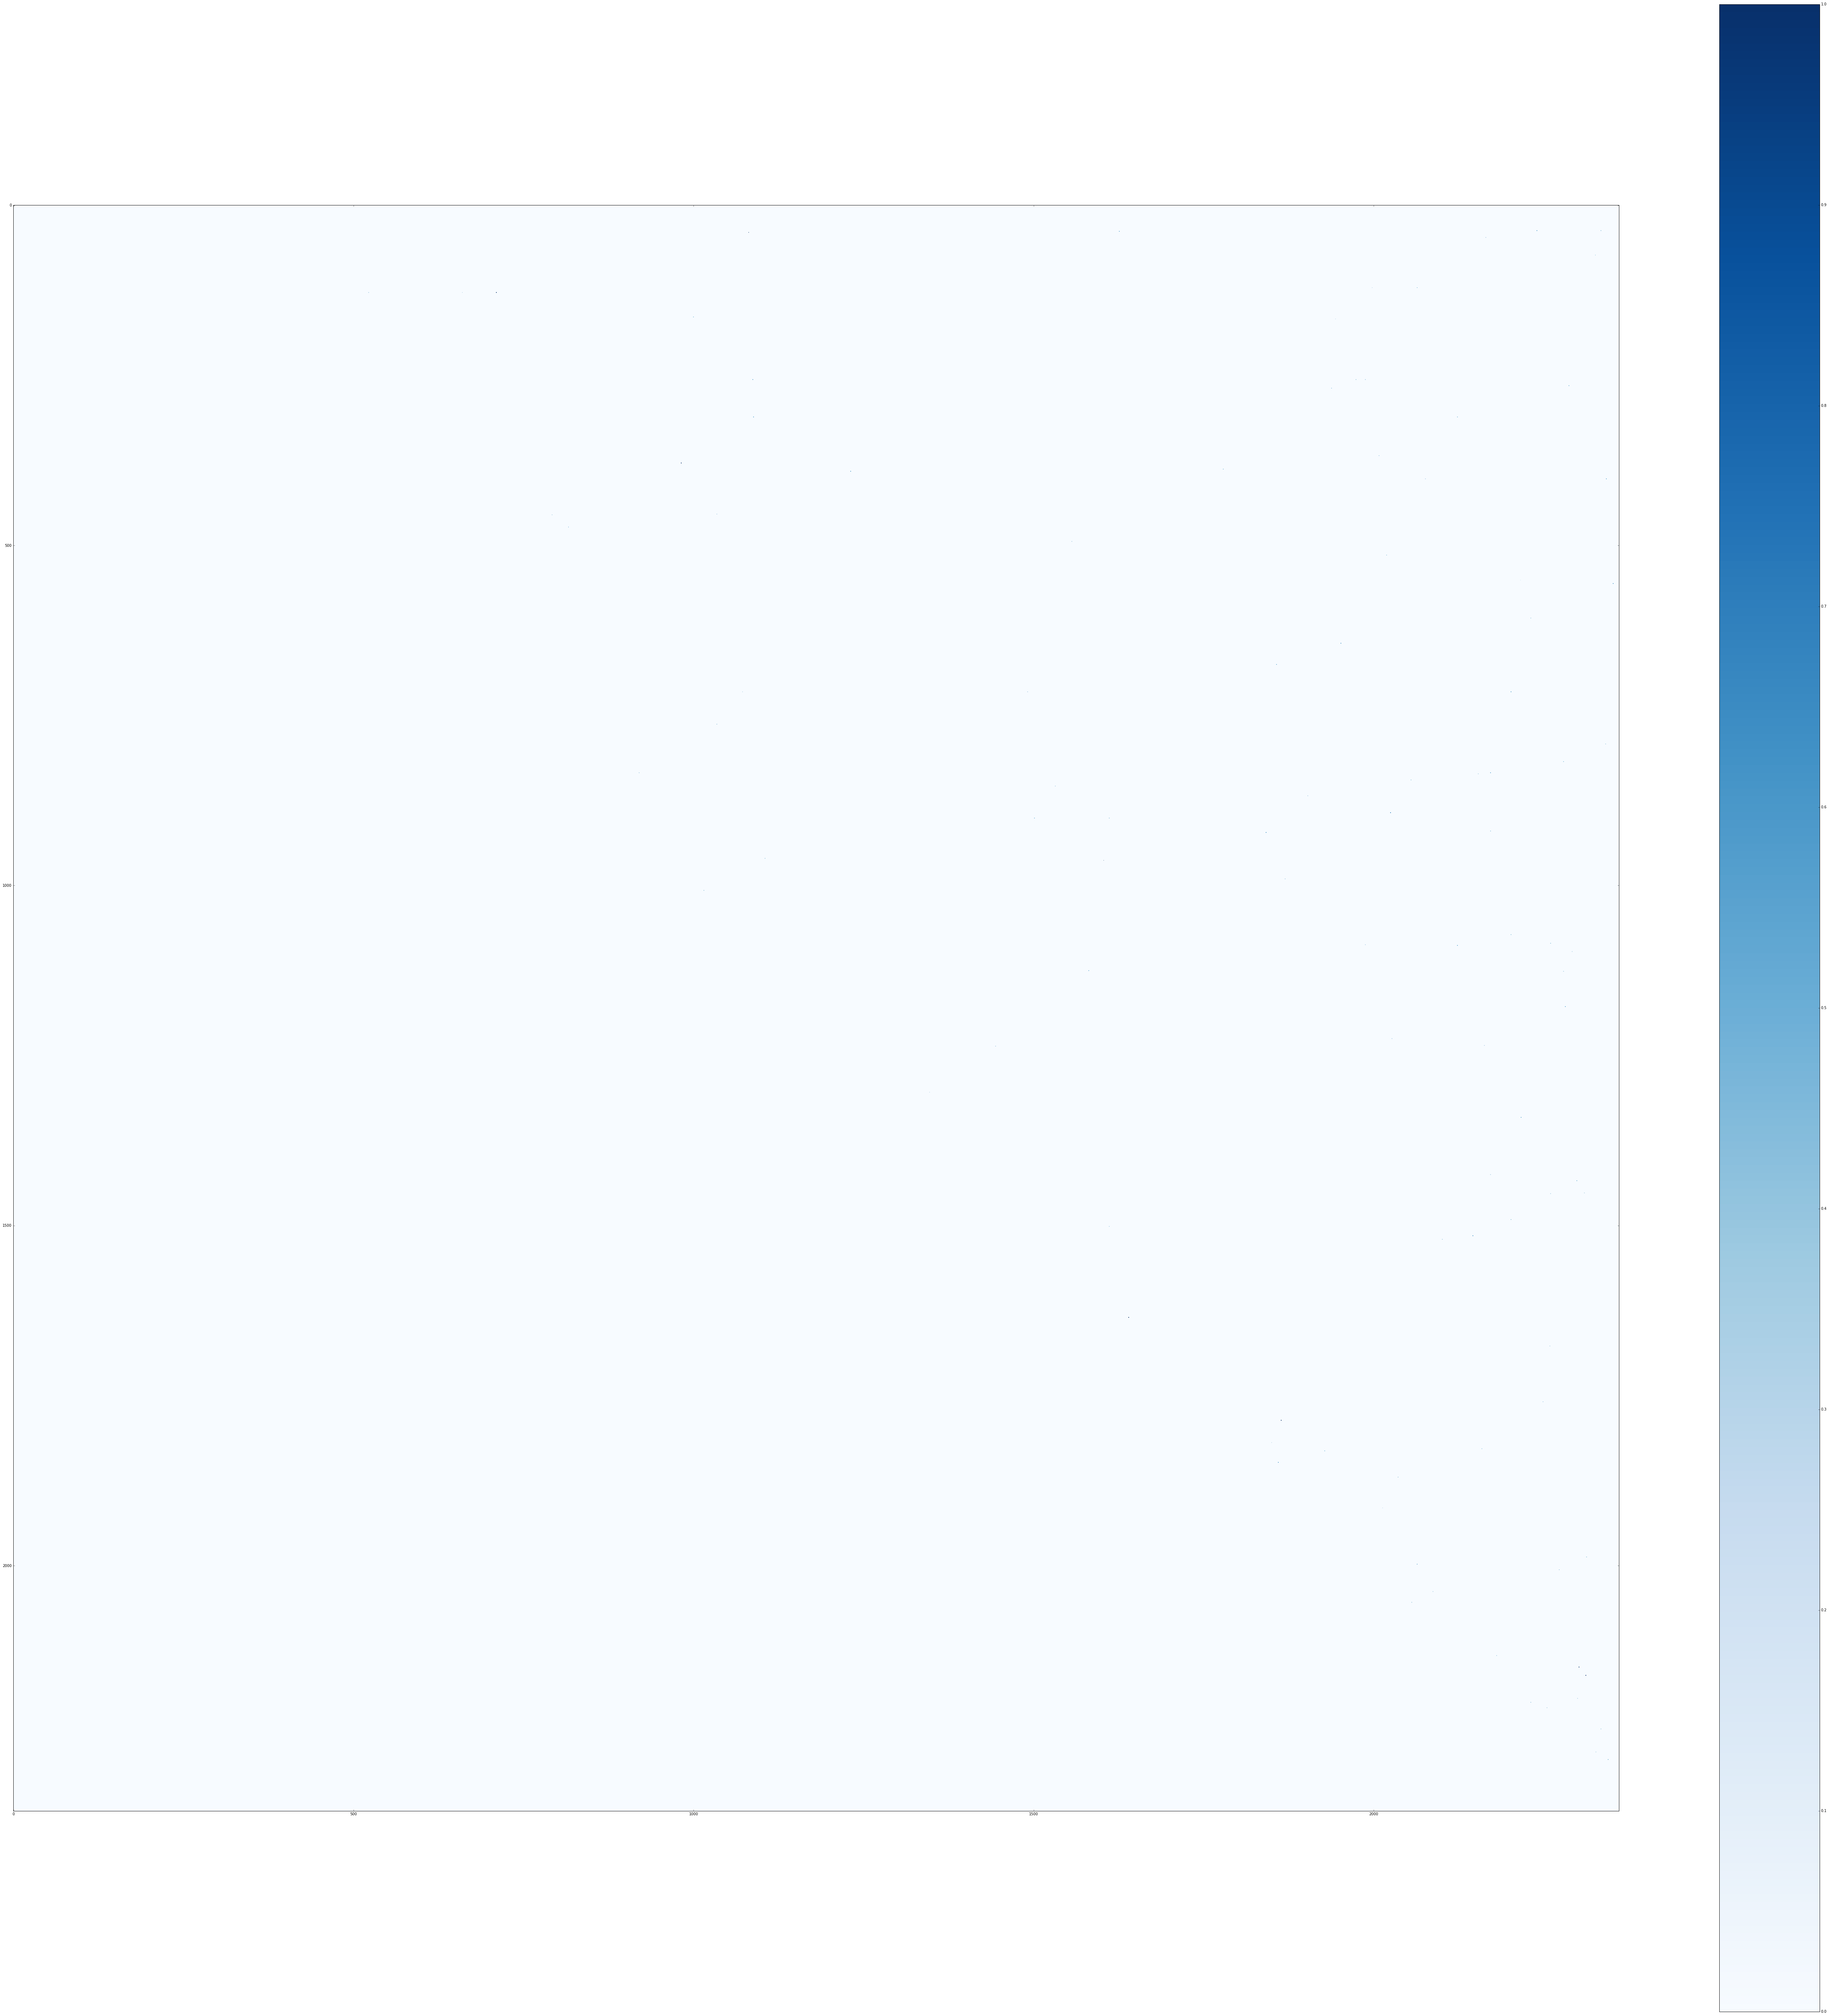

In [598]:
figure, axes = pyplot.subplots(figsize=(100,100))
cax = axes.imshow(msisdns_pairs_matrix.toarray(), interpolation="none", cmap=cm.Blues)
colorbar = figure.colorbar(cax)
pyplot.savefig('pairs_matrix.png', bbox_inches='tight')

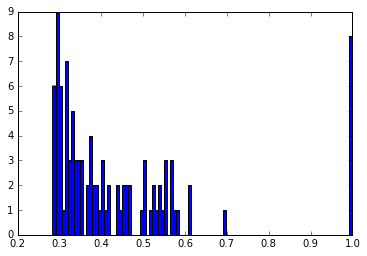

In [599]:
pyplot.hist(msisdns_pairs_matrix[msisdns_pairs_matrix.nonzero()].toarray()[0],bins=100)
pyplot.show()

### Проверяем качество классификации по известным персонам

In [600]:
# на тестовой выборке сверяем полученные результаты с известными парами
# допускаем, что величина меры сходства не имеет значения, а важен сам факт найденного сходства пары сим-карт
# допускаем, что по известным парам сходство равно единице

# заполняем нижний треугольник матрицы сходства для корректной работы с известными парами
msisdns_pairs_matrix = msisdns_pairs_matrix.copy() + msisdns_pairs_matrix.copy().transpose()

In [601]:
# для каждой пары сим-карт из известных находим наличие рассчитанного признака сходства в матрице попарных соответствий
false_negatives = 0
for msisdn_pair in known_personas_data.itertuples():
    predicted_value = msisdns_pairs_matrix[np.where(unique_msisdns == msisdn_pair[1]), \
                                           np.where(unique_msisdns == msisdn_pair[2])  \
                                          ].nnz
    #print(msisdn_pair[0], ":", msisdn_pair[1],"-", msisdn_pair[2], "схожесть составила", predicted_value)
    false_negatives += (1 - predicted_value)

print("Общее кол-во ошибок на тестовой выборке:", false_negatives, "из", known_personas_data.shape[0],"известных пар")

Общее кол-во ошибок на тестовой выборке: 113 из 122 известных пар


### Выделяем персоны среди пар похожих сим-карт

In [606]:
# Для выделения персон из имеющихся пар сим-карт, представляем найденные пары как ненаправленный граф,
# в котором сим-карты - вершины, рёбра - сходство между парой сим-карт.
# На таком графе можно будет выделить подграфы, состоящие из вершин, связанных между собой ненулевыми связями.
# Персоной будет являться подграф с кол-вом вершин больше одной.
# Для поиска таких подграфов используем алгоритм поиска в глубину
from scipy.sparse.csgraph import connected_components
n_components, component_list = connected_components(msisdns_pairs_matrix, directed=False)
print("Найдено подграфов:", n_components)

Найдено подграфов: 2267


In [608]:
personas_found = {}
persona_counter = 0
#print("Найденные персоны:")
for i in range(n_components):
    # запоминаем подграфы с кол-во вершины больше одной
    if np.sum(component_list == i) > 1:
        persona_counter += 1
        personas_found.update({persona_counter: unique_msisdns[component_list == i]})
        #print("№"+str(persona_counter)+":", unique_msisdns[component_list == i])

### Выгружаем перечень персон с номерами

In [609]:
with open("personas.txt", mode="w") as output_file:
    for key, value in personas_found.items():
        output_file.write(str(key) + ": " + str(value) + "\n")
        
print("Список персон выгружен в personas.txt")

Список персон выгружен в personas.txt


### Операции с промежуточными расчётами

In [160]:
from scipy.io import savemat, loadmat

In [161]:
savemat("msisdns_pairs_matrix.mat", {"msisdns_pairs_matrix":msisdns_pairs_matrix}, appendmat=False, do_compression=True)

In [594]:
msisdns_pairs_matrix = loadmat("msisdns_pairs_matrix_24.mat",appendmat=False)["msisdns_pairs_matrix"].tolil().asfptype()

### Изучаем существующие данные

In [32]:
for msisdn_pair in known_personas_data.itertuples():
    print("Персона:",msisdn_pair[0], \
          " кол-во событий:",events[events["msisdn"] == msisdn_pair[1]].shape[0], \
                         "+",events[events["msisdn"] == msisdn_pair[2]].shape[0])

Персона: 0  кол-во событий: 60 + 2
Персона: 1  кол-во событий: 77 + 0
Персона: 2  кол-во событий: 47 + 39
Персона: 3  кол-во событий: 70 + 35
Персона: 4  кол-во событий: 153 + 47
Персона: 5  кол-во событий: 56 + 89
Персона: 6  кол-во событий: 35 + 14
Персона: 7  кол-во событий: 30 + 2
Персона: 8  кол-во событий: 105 + 21
Персона: 9  кол-во событий: 73 + 3
Персона: 10  кол-во событий: 30 + 18
Персона: 11  кол-во событий: 60 + 3
Персона: 12  кол-во событий: 93 + 57
Персона: 13  кол-во событий: 64 + 49
Персона: 14  кол-во событий: 116 + 56
Персона: 15  кол-во событий: 78 + 22
Персона: 16  кол-во событий: 368 + 60
Персона: 17  кол-во событий: 368 + 0
Персона: 18  кол-во событий: 153 + 9
Персона: 19  кол-во событий: 54 + 37
Персона: 20  кол-во событий: 70 + 47
Персона: 21  кол-во событий: 63 + 22
Персона: 22  кол-во событий: 61 + 62
Персона: 23  кол-во событий: 27 + 42
Персона: 24  кол-во событий: 8 + 18
Персона: 25  кол-во событий: 40 + 14
Персона: 26  кол-во событий: 21 + 77
Персона: 27  

In [160]:
known_persona_row = 4
events[["time","msisdn","imei","station_id","event_type","cell_type","max_dist","start_angle","end_angle"]][
    (events["msisdn"] == known_personas_data.ix[known_persona_row, 0]) | 
    (events["msisdn"] == known_personas_data.ix[known_persona_row, 1])
]

,time,msisdn,imei,station_id,event_type,cell_type,max_dist,start_angle,end_angle
1172,2013-05-22 23:35:21,158528852153,358218030846220,"771761172 55.6585, 37.5916",0,OUTDOOR,1101,95.0,155.0
7286,2013-05-23 06:07:39,158528852153,358218030846220,"771633267 55.6687, 37.5775",0,OUTDOOR,1316,90.0,150.0
7287,2013-05-23 06:07:39,158528852153,358218030846220,"771761172 55.6585, 37.5916",3,OUTDOOR,1101,95.0,155.0
7339,2013-05-23 06:10:25,158528852153,358218030846220,"771761286 55.6585, 37.5916",0,OUTDOOR,1100,350.0,50.0
12531,2013-05-23 08:34:48,158528861475,355869030232060,"771761628 55.6567, 37.5971",2,OUTDOOR,1101,155.0,215.0
12927,2013-05-23 08:44:23,158528861475,355869030232060,"77361110 55.663999999999994, 37.6071",0,OUTDOOR,500,315.0,45.0
13891,2013-05-23 09:07:24,158528861475,355869030232060,"7763110 55.7614, 37.6243",0,METRO,100,315.0,45.0
13987,2013-05-23 09:09:31,158528861475,355869030232060,"776710016 55.761, 37.6241",0,OUTDOOR,500,350.0,50.0
14987,2013-05-23 09:29:48,158528852153,358218030846220,"771633262 55.6687, 37.5775",0,OUTDOOR,1508,90.0,150.0
15013,2013-05-23 09:30:27,158528852153,358218030846220,"771759981 55.6585, 37.5916",0,OUTDOOR,518,350.0,50.0


In [161]:
print(known_personas_data.ix[known_persona_row, 0],known_personas_data.ix[known_persona_row, 1])

158528852153 158528861475
